In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# pip install ydata-profiling[notebook,html]
from ydata_profiling.utils.cache import cache_file

# 1 Mini ETL

## 1.1 Carga de los datos

In [17]:
data1 = pd.read_csv('..\Archivos_csv\homicidios.csv')
data2 = pd.read_csv('..\Archivos_csv\lesiones.csv')

In [18]:
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [19]:
siniestros_df = pd.concat([df1, df2], ignore_index=True)

## 1.2 Formatos y tipos

In [20]:
siniestros_df['TIPO_DE_CALLE'] = siniestros_df['TIPO_DE_CALLE'].astype('category')
siniestros_df['COMUNA'] = siniestros_df['COMUNA'].astype('category')
siniestros_df['VICTIMA'] = siniestros_df['VICTIMA'].astype('category')
siniestros_df['ACUSADO'] = siniestros_df['ACUSADO'].astype('category')
siniestros_df['FECHA_Y_HORA'] = pd.to_datetime(siniestros_df['FECHA_Y_HORA'])

In [21]:
siniestros_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24477 entries, 0 to 24476
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               24477 non-null  int64         
 1   N_VICTIMAS       24477 non-null  int64         
 2   LUGAR_DEL_HECHO  24477 non-null  object        
 3   TIPO_DE_CALLE    24477 non-null  category      
 4   COMUNA           24477 non-null  category      
 5   LONGITUD         24477 non-null  float64       
 6   LATITUD          24477 non-null  float64       
 7   VICTIMA          24477 non-null  category      
 8   ACUSADO          24477 non-null  category      
 9   FECHA_Y_HORA     18820 non-null  datetime64[ns]
 10  FATAL            24477 non-null  bool          
dtypes: bool(1), category(4), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 1.2+ MB


In [22]:
siniestros_df['COMUNA'] = siniestros_df['COMUNA'].astype(str).str.lstrip('0')

## 1.3 Valores nulos

In [23]:
siniestros_df = siniestros_df[(siniestros_df['VICTIMA'] != 'SD') & (siniestros_df['ACUSADO'] != 'SD')]

Eliminar ceros a la izquierda y convertir a tipo str

## 1.4 Transformamos a CSV

In [34]:
siniestros_df.to_csv('../Archivos_csv/siniestros.csv')

# 2 EDA Completo

## 2.1 ```Pandas Profiling```

In [32]:
report = siniestros_df.profile_report(sort=None, html={'style':{'full_width':True}})

In [33]:
report

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


* Podemos observar atraves del EDA de `ydata-profiling` que la columna `FATAL` esta altamente desbalanzeada viendo que los Registros que presentan victimas fatales son `1122` y los no fatales son `11558` esto se debe a que el datasets de mayor de tamaño `lesiones` no presentaba casi siniestros fatales.
* Dentro de la columna `N_VICTIMAS` vemos que el maximo fue `10` pero la media se mantenia en `1`.
* Viendo la columna `TIPO_DE_CALLE` la avenida se mantiene primero con un `54,2%` de los siniestros ocurriendo en esta.
* `COMUNA`, los valores en esta columna se distribuyen con una mayoria en la categoria `Comuna 1` siendo esta conformada por los barrios de: Retiro, San Nicolás, Puerto Madero, San Telmo, Montserrat y Constitución.
* Cabe a destacar que dentro de la columna `FECHA_Y_HORA` hay un `33,6%` de valores faltantes.
* En el apartado de `Correlaciones` no se ve ningun tipo de correlacion entre las variables.
* Por ultimo podemos resaltar que no encontro `registros duplicados` en el dataframe.

In [35]:
report.to_file(output_file='siniestros_report_eda.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


Finalmente la librería nos ofrece la posibilidad de exportar el informe a html, lo cuál es útil para mostrarlo en un ambiente más amigable para el usuario final. En el cual puede incluso interactuar por medio de barras de navegación.

## 2.2 ```Graficos Extras```

C:\Users\Luka\AppData\Local\Temp\ipykernel_14624\610672611.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agrupado = siniestros_df.groupby(['TIPO_DE_CALLE', 'COMUNA'])['N_VICTIMAS'].sum().reset_index()
C:\Users\Luka\AppData\Local\Temp\ipykernel_14624\610672611.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla_pivote = agrupado.pivot_table(index='COMUNA', columns='TIPO_DE_CALLE', values='N_VICTIMAS', aggfunc='sum')


<Figure size 2000x1000 with 0 Axes>

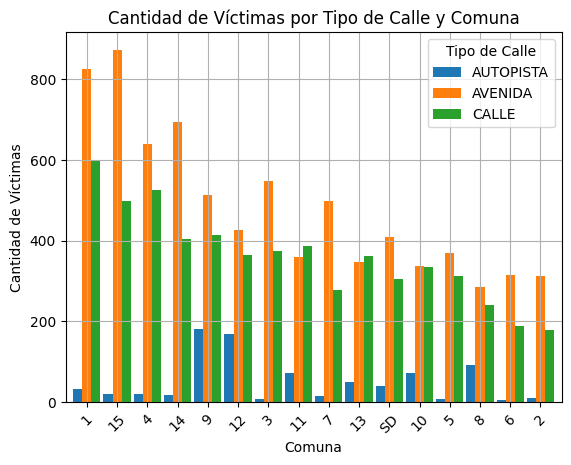

In [26]:
# Agrupar los datos por tipo de calle y comuna, y contar el número de víctimas en cada grupo
agrupado = siniestros_df.groupby(['TIPO_DE_CALLE', 'COMUNA'])['N_VICTIMAS'].sum().reset_index()

# Crear una tabla pivote para organizar los datos adecuadamente
tabla_pivote = agrupado.pivot_table(index='COMUNA', columns='TIPO_DE_CALLE', values='N_VICTIMAS', aggfunc='sum')

# Calcular el total de víctimas por comuna y ordenar las comunas por el total de víctimas en orden descendente
comunas_ordenadas = tabla_pivote.sum(axis=1).sort_values(ascending=False).index

# Reordenar el DataFrame de acuerdo al orden de las comunas
tabla_pivote = tabla_pivote.loc[comunas_ordenadas]

# Crear el gráfico de barras
plt.figure(figsize=(20, 10))
tabla_pivote.plot(kind='bar', width=0.9)  # Ajustar el ancho de las barras

# Personalizar el gráfico
plt.xlabel('Comuna')
plt.ylabel('Cantidad de Víctimas')
plt.title('Cantidad de Víctimas por Tipo de Calle y Comuna')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
plt.legend(title='Tipo de Calle')
plt.grid(True)  # Mostrar cuadrícula
plt.show()

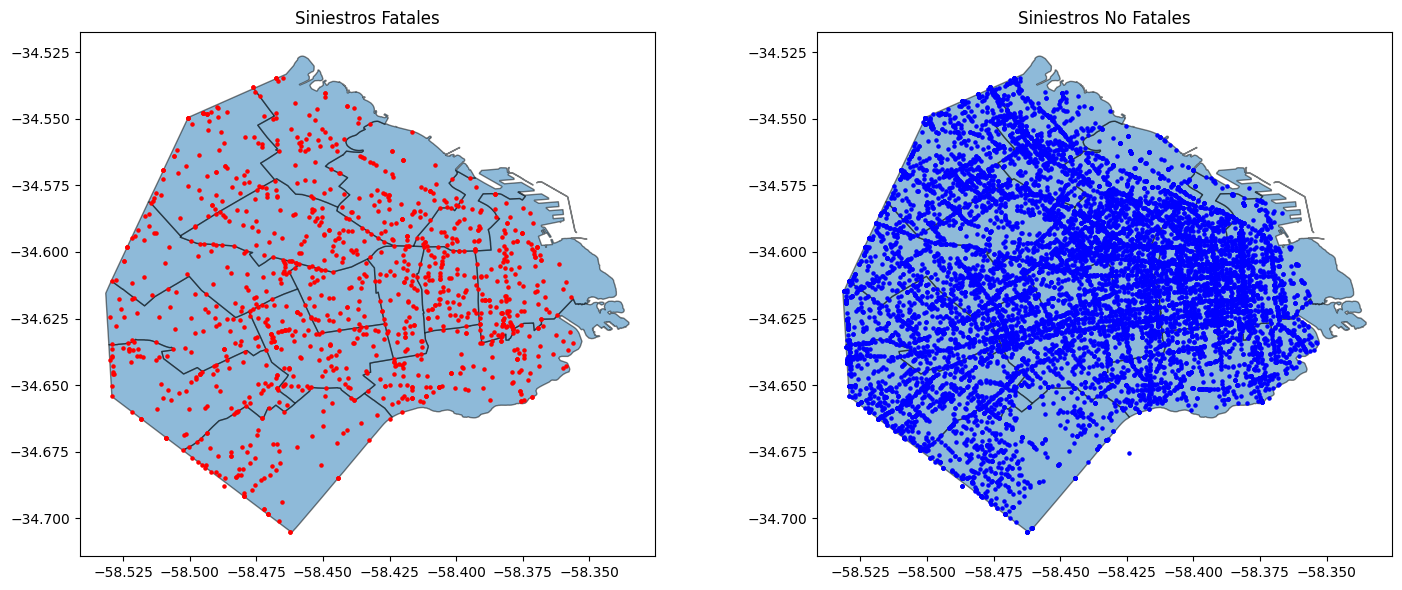

In [27]:
# Cargar los datos geoespaciales de los barrios de CABA
barrios_caba = gpd.read_file('../Mapas/CABA.geojson')  # Reemplaza '../Mapas/CABA.geojson' con la ubicación de tu archivo

# Crear dos GeoDataFrames separados para siniestros fatales y no fatales
siniestros_fatal = gpd.GeoDataFrame(siniestros_df[siniestros_df['FATAL']], geometry=gpd.points_from_xy(siniestros_df[siniestros_df['FATAL']]['LONGITUD'], siniestros_df[siniestros_df['FATAL']]['LATITUD']))
siniestros_no_fatal = gpd.GeoDataFrame(siniestros_df[~siniestros_df['FATAL']], geometry=gpd.points_from_xy(siniestros_df[~siniestros_df['FATAL']]['LONGITUD'], siniestros_df[~siniestros_df['FATAL']]['LATITUD']))

# Crear subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Mapa de siniestros fatales
barrios_caba.plot(ax=axs[0], edgecolor='black', alpha=0.5)
siniestros_fatal.plot(ax=axs[0], color='red', markersize=5)
axs[0].set_title('Siniestros Fatales')

# Mapa de siniestros no fatales
barrios_caba.plot(ax=axs[1], edgecolor='black', alpha=0.5)
siniestros_no_fatal.plot(ax=axs[1], color='blue', markersize=5)
axs[1].set_title('Siniestros No Fatales')

# Ajustar diseño
plt.tight_layout()
plt.show()


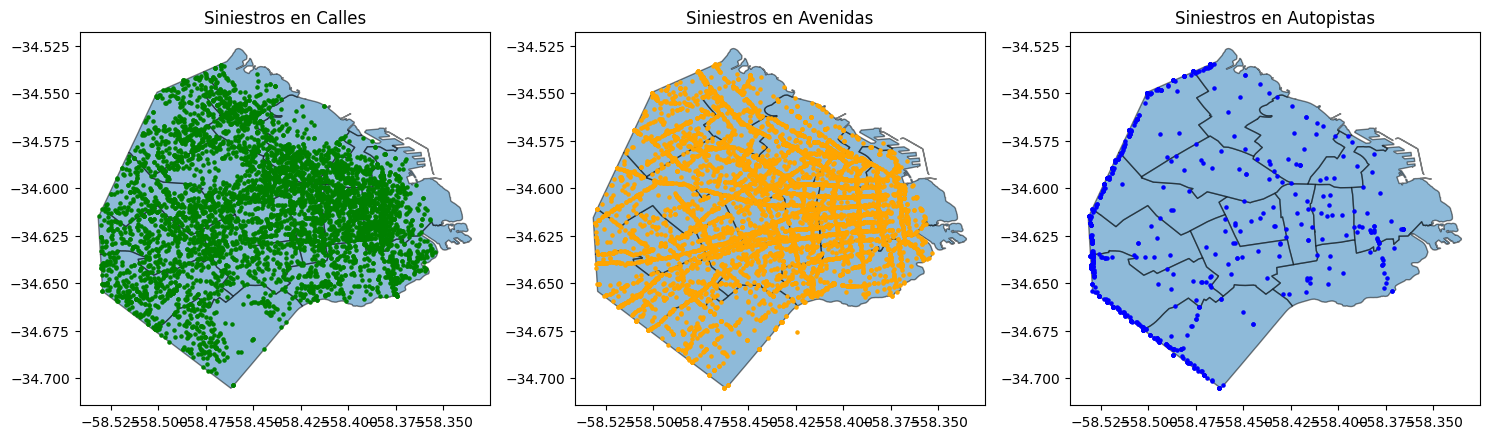

In [28]:
# Cargar los datos geoespaciales de los barrios de CABA
barrios_caba = gpd.read_file('../Mapas/CABA.geojson')  # Reemplaza '../Mapas/CABA.geojson' con la ubicación de tu archivo

# Filtrar siniestros por tipo de calle
siniestros_calle = siniestros_df[siniestros_df['TIPO_DE_CALLE'] == 'CALLE']
siniestros_avenida = siniestros_df[siniestros_df['TIPO_DE_CALLE'] == 'AVENIDA']
siniestros_autopista = siniestros_df[siniestros_df['TIPO_DE_CALLE'] == 'AUTOPISTA']

# Crear GeoDataFrames para cada tipo de calle
siniestros_calle = gpd.GeoDataFrame(siniestros_calle, geometry=gpd.points_from_xy(siniestros_calle['LONGITUD'], siniestros_calle['LATITUD']))
siniestros_avenida = gpd.GeoDataFrame(siniestros_avenida, geometry=gpd.points_from_xy(siniestros_avenida['LONGITUD'], siniestros_avenida['LATITUD']))
siniestros_autopista = gpd.GeoDataFrame(siniestros_autopista, geometry=gpd.points_from_xy(siniestros_autopista['LONGITUD'], siniestros_autopista['LATITUD']))

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Mapa de siniestros en calles
barrios_caba.plot(ax=axs[0], edgecolor='black', alpha=0.5)
siniestros_calle.plot(ax=axs[0], color='green', markersize=5)
axs[0].set_title('Siniestros en Calles')

# Mapa de siniestros en avenidas
barrios_caba.plot(ax=axs[1], edgecolor='black', alpha=0.5)
siniestros_avenida.plot(ax=axs[1], color='orange', markersize=5)
axs[1].set_title('Siniestros en Avenidas')

# Mapa de siniestros en autopistas
barrios_caba.plot(ax=axs[2], edgecolor='black', alpha=0.5)
siniestros_autopista.plot(ax=axs[2], color='blue', markersize=5)
axs[2].set_title('Siniestros en Autopistas')

# Ajustar diseño
plt.tight_layout()
plt.show()


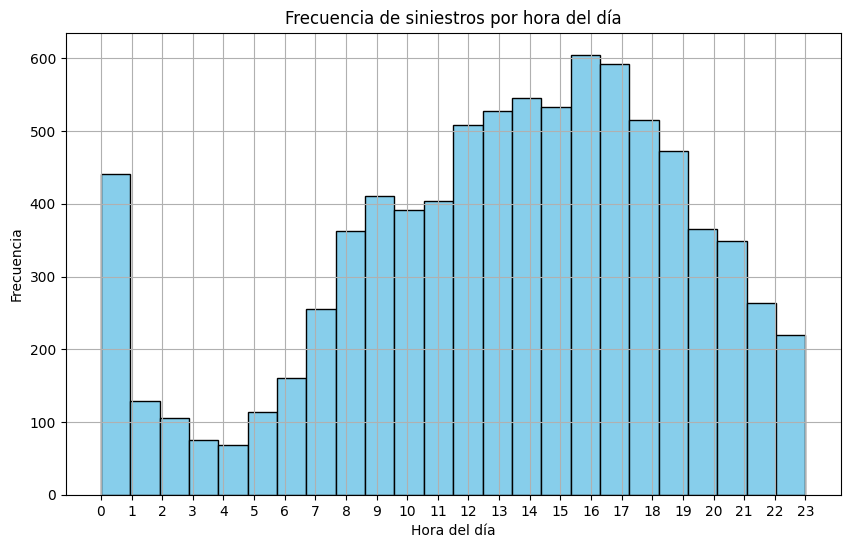

In [29]:
# Creamos la columna 'HORA' para visualizar los datos
siniestros_df['HORA'] = siniestros_df['FECHA_Y_HORA'].dt.hour

# Crear el histograma de las horas del día
plt.figure(figsize=(10, 6))
siniestros_df['HORA'].hist(bins=24, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.xlabel('Hora del día')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de siniestros por hora del día')
plt.xticks(range(0, 24))  # Mostrar todas las horas del día en el eje x
plt.grid(True)  # Mostrar cuadrícula

# Mostrar el histograma
plt.show()
siniestros_df.drop(columns='HORA', inplace=True)

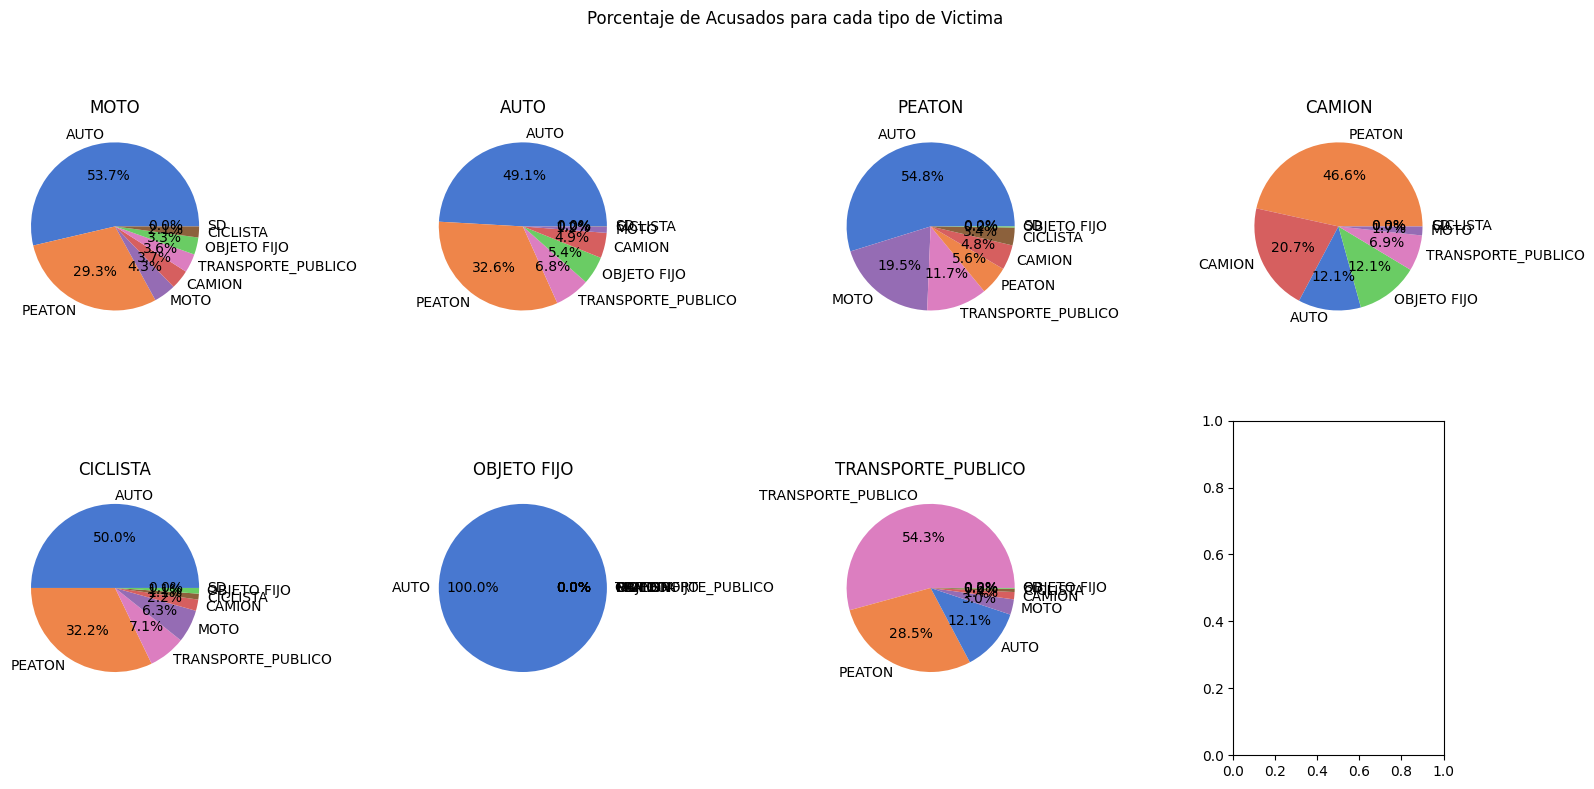

In [30]:
# Filtrar los datos para excluir la víctima "SD"
datos_torta = siniestros_df[(siniestros_df['VICTIMA'] != 'SD') & (siniestros_df['ACUSADO'] != 'SD')]

# Crear el diccionario de colores para cada acusado
colores_acusados = sns.color_palette('muted', n_colors=len(datos_torta['ACUSADO'].unique())).as_hex()
diccionario_colores = {acusado: color for acusado, color in zip(datos_torta['ACUSADO'].unique(), colores_acusados)}

# Crear la figura y los subgráficos
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

# Calcular los valores más frecuentes para cada víctima
for i, victima in enumerate(datos_torta['VICTIMA'].unique()):
    # Filtrar los datos para la víctima actual
    datos_victima = datos_torta[datos_torta['VICTIMA'] == victima]
    top_acusados = datos_victima['ACUSADO'].value_counts()
    
    # Crear el gráfico de torta para la víctima actual
    axs[i].pie(top_acusados, labels=top_acusados.index, autopct='%1.1f%%', colors=[diccionario_colores.get(acusado, 'gray') for acusado in top_acusados.index])
    axs[i].set_title(f'{victima}')

# Ajustar el diseño
plt.suptitle('Porcentaje de Acusados para cada tipo de Victima')
plt.tight_layout()
plt.show()


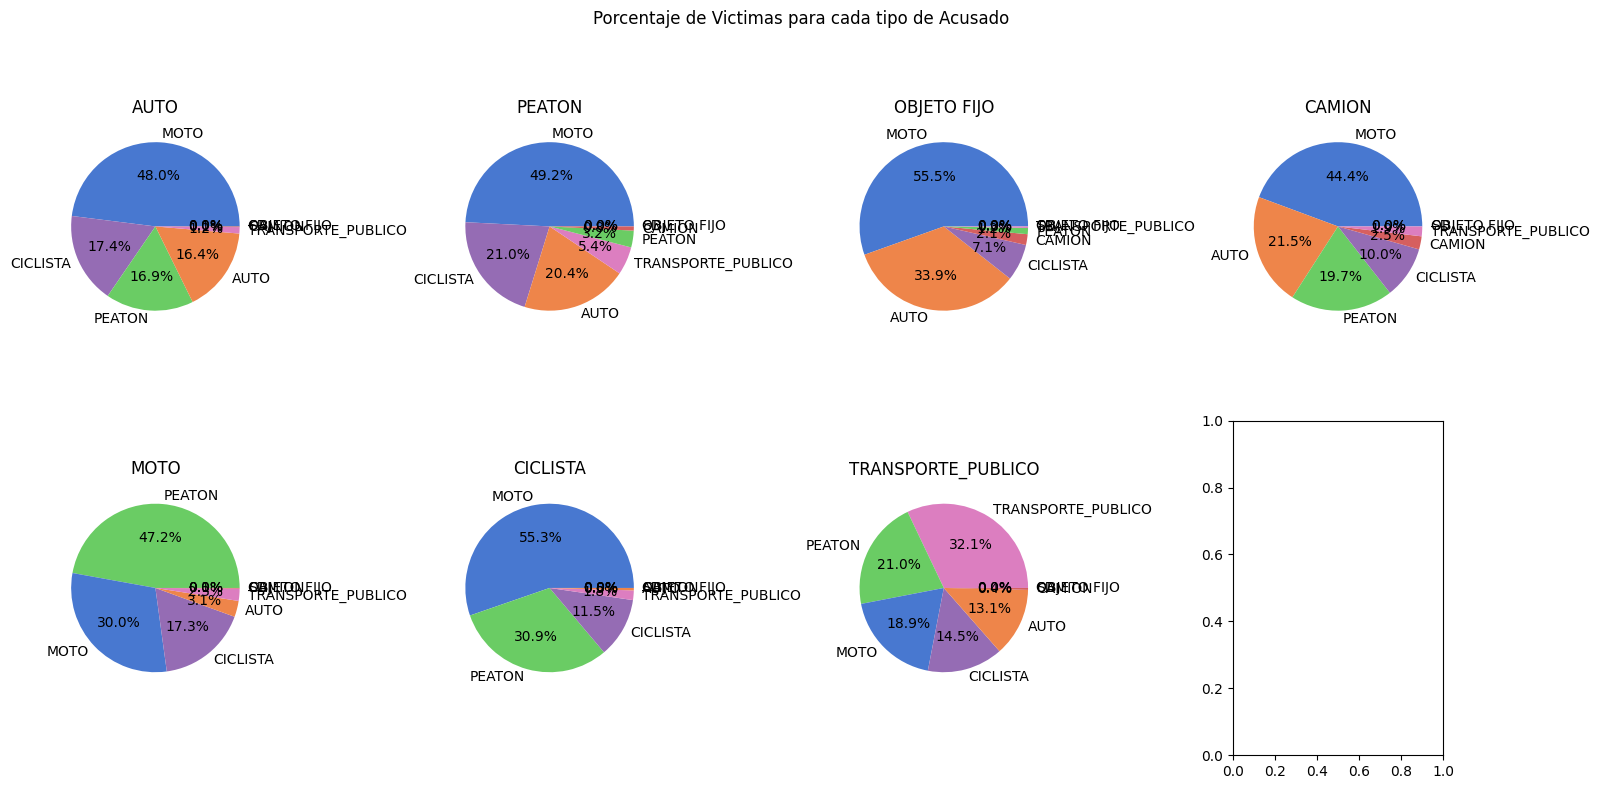

In [31]:
# Filtrar los datos para excluir la víctima "SD"
datos_torta = siniestros_df[(siniestros_df['VICTIMA'] != 'SD') & (siniestros_df['ACUSADO'] != 'SD')]

# Crear el diccionario de colores para cada acusado
colores_victimas = sns.color_palette('muted', n_colors=len(datos_torta['VICTIMA'].unique())).as_hex()
diccionario_colores = {acusado: color for acusado, color in zip(datos_torta['VICTIMA'].unique(), colores_victimas)}

# Crear la figura y los subgráficos
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

# Calcular los valores más frecuentes para cada víctima
for i, victima in enumerate(datos_torta['ACUSADO'].unique()):
    # Filtrar los datos para la víctima actual
    datos_acusados = datos_torta[datos_torta['ACUSADO'] == victima]
    top_acusados = datos_acusados['VICTIMA'].value_counts()
    
    # Crear el gráfico de torta para la víctima actual
    axs[i].pie(top_acusados, labels=top_acusados.index, autopct='%1.1f%%', colors=[diccionario_colores.get(acusado, 'gray') for acusado in top_acusados.index])
    axs[i].set_title(f'{victima}')

# Ajustar el diseño
plt.suptitle('Porcentaje de Victimas para cada tipo de Acusado')
plt.tight_layout()
plt.show()